<a href="https://colab.research.google.com/github/sunilkumarrudragada/Automatic_Ticket_Classification_Nlp/blob/master/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [3]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# mount google drivw
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file
f = open('/content/drive/MyDrive/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

In [6]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
print(f'shape of dataframe {df.shape}')

(78313, 22)

In [9]:
#print the column names
print(f'column Names: {df.columns.values}')

array(['_index', '_type', '_id', '_score', '_source.tags',
       '_source.zip_code', '_source.complaint_id', '_source.issue',
       '_source.date_received', '_source.state',
       '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company',
       '_source.submitted_via', '_source.date_sent_to_company',
       '_source.company_public_response', '_source.sub_product',
       '_source.timely', '_source.complaint_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype=object)

In [10]:
print(f'length of columns: {len(df.columns.values)}')

22

In [11]:
#Assign new column names
df.columns=df.columns.str.replace(r'^_?(source\.)?', '', regex=True).values

In [12]:
print(f'column Names after renaming: {df.columns.values}')

array(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response', 'sub_product',
       'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided'], dtype=object)

In [13]:
print(f'length of columns after renaming to ensure no column is removed: {len(df.columns.values)}')

22

In [14]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [15]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened']=df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [16]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [17]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [18]:
print('shape of df after removing empty strings in complaint_what_happened', df.shape)

shape of df after removing empty strings in complaint_what_happened (21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [19]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower() # lowercase
  text = re.sub('\[.*?\]', '', text) # Remove text in square brackets
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)# Remove punctuation
  text = re.sub('\w*\d\w*', '', text)# Remove words containing numbers
  return text

In [20]:
#Write your function to Lemmatize the texts
nlp=spacy.load('en_core_web_sm')
def lemmatize_texts(texts, batch_size=1000, n_process=4):
    """
    Lemmatizes a list of texts using spaCy's nlp.pipe for efficiency.

    Args:
        texts (list or pd.Series): List of text strings to lemmatize
        batch_size (int): Number of texts processed per batch
        n_process (int): Number of CPU processes to use

    Returns:
        list: Lemmatized texts as strings
    """
    results = []
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process), total=len(texts)):
        lemmas = [token.lemma_ for token in doc]
        results.append(" ".join(lemmas))
    return results

In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
from tqdm import tqdm
tqdm.pandas()
df_clean = pd.DataFrame()

df_clean['complaints'] = df['complaint_what_happened']

df['cleaned_complaints'] = df['complaint_what_happened'].progress_apply(clean_text)

df_clean['lemmatized_complaints'] = lemmatize_texts(df['cleaned_complaints'].tolist())

100%|██████████| 21072/21072 [03:27<00:00, 101.69it/s]


In [22]:
df_clean.head()

,complaints,lemmatized_complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...


In [23]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
  # text is an array
  results = []
  for doc in tqdm(nlp.pipe(text, batch_size=1000, n_process=4), total=len(text)):
    tokenText = [token.lemma_ for token in doc if token.tag_ == "NN"]
    results.append(" ".join(tokenText))
  return results



df_clean["complaint_POS_removed"] = pos_tag(df_clean['lemmatized_complaints']) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


100%|██████████| 21072/21072 [03:24<00:00, 103.15it/s]


In [24]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




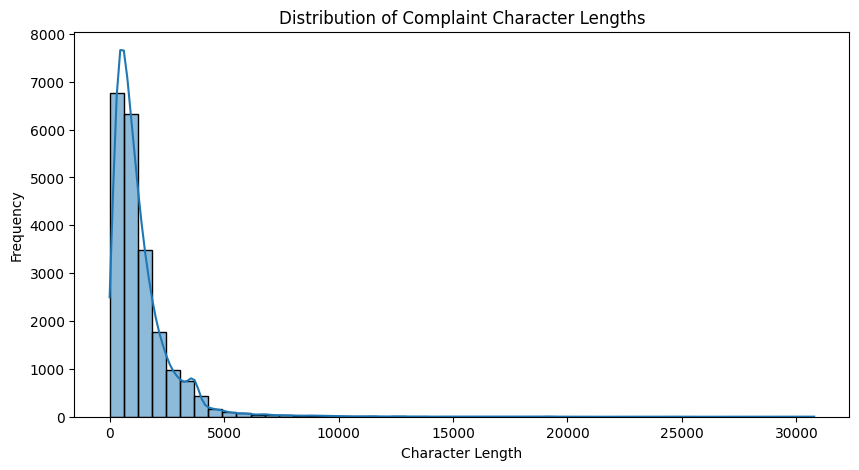

In [25]:
# Write your code here to visualise the data according to the 'Complaint' character length
# Calculate character length of each complaint
df_clean['complaint_length'] = df_clean['complaints'].str.len()

# histogram
plt.figure(figsize=(10,5))
sns.histplot(df_clean['complaint_length'], bins=50, edgecolor='black', kde=True)
plt.title("Distribution of Complaint Character Lengths")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [33]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
text=' '.join(df_clean['complaint_POS_removed'])
wordcloud = WordCloud(width=800, height=500, background_color='white', max_words=40).generate(text)

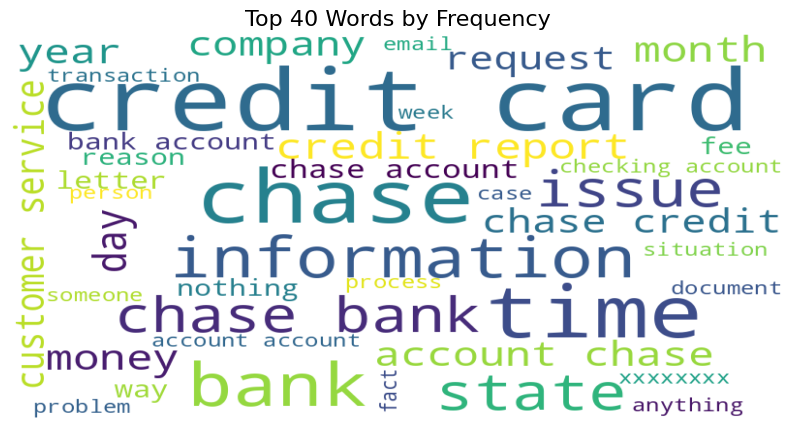

In [42]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis('off')
plt.title('Top 40 Words by Frequency', fontsize=16)
plt.show()

In [35]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [43]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,475,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,337,card agent anniversary date agent information order account anniversary date consent recording a...
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,210,chase card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1433,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,456,son chase account fund chase bank account money son check money chase bank money son chase time ...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [60]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_clean['complaints'])

In [61]:
words=vectorizer.get_feature_names_out()
frequency=X.toarray().sum(axis=0)
word_freq=pd.DataFrame({'word':words,'frequency':frequency})

top_30_unigrams = word_freq.sort_values(by='frequency', ascending=False).head(30)

print(top_30_unigrams)

              word  frequency
32605         xxxx     192551
4750         chase      79844
226        account      42584
6912        credit      32671
32952     xxxxxxxx      27916
4182          card      26838
2667          bank      26644
29486         told      16377
8322           did      15986
20758      payment      13965
4018        called      13403
23384     received      12854
29316         time      11967
18198        money      11945
25499         said      10880
16709         loan      10005
4893         check       9708
14681  information       9644
16409       letter       8425
26078         sent       8328
18350     mortgage       7932
20725          pay       7850
19407       number       7740
21193        phone       7499
7385          days       7465
1962         asked       7451
24375       report       7356
20778     payments       7203
2609       balance       7195
11974        fraud       7060


In [55]:
#Print the top 10 words in the unigram frequency
print(top_30_unigrams[: 10])

           word  frequency
32605      xxxx     192551
4750      chase      79844
226     account      42584
6912     credit      32671
32952  xxxxxxxx      27916
4182       card      26838
2667       bank      26644
29486      told      16377
8322        did      15986
20758   payment      13965


In [62]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer = CountVectorizer(stop_words='english', ngram_range=(2,2))
X = vectorizer.fit_transform(df_clean['complaints'])

words=vectorizer.get_feature_names_out()
frequency=X.toarray().sum(axis=0)
word_freq=pd.DataFrame({'word':words,'frequency':frequency})

top_30_bigrams = word_freq.sort_values( by='frequency', ascending=False).head(30)

print(top_30_bigrams)

                     word  frequency
770744          xxxx xxxx      83071
121255         chase bank      12606
178420        credit card      10903
764198         xxxx chase       3943
96026        called chase       3688
128851   checking account       3550
179604      credit report       3237
774625      xxxxxxxx xxxx       3199
184839   customer service       3014
770875      xxxx xxxxxxxx       2940
372368          jp morgan       2862
125841         chase xxxx       2818
441105       morgan chase       2465
774639  xxxxxxxx xxxxxxxx       2452
121908       chase credit       2376
8827         account xxxx       2331
5567        account chase       1976
194505         debit card       1933
178434       credit cards       1879
763140       xxxx account       1772
163660    contacted chase       1734
69178        bank account       1704
461366        number xxxx       1676
764737        xxxx credit       1617
5618       account closed       1607
179717       credit score       1582
7

In [57]:
#Print the top 10 words in the bigram frequency
print(top_30_bigrams[: 10])

In [63]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer = CountVectorizer(stop_words='english', ngram_range=(3,3))
X = vectorizer.fit_transform(df_clean['complaints'])

words=vectorizer.get_feature_names_out()
frequency=X.toarray().sum(axis=0)
word_freq=pd.DataFrame({'word':words,'frequency':frequency})

top_30_trigrams = word_freq.sort_values( by='frequency', ascending=False).head(30)

print(top_30_trigrams)

                               word  frequency
1674210              xxxx xxxx xxxx      39231
809155              jp morgan chase       2339
290598            chase credit card       1810
1669931             xxxx xxxx chase       1654
1691586          xxxxxxxx xxxx xxxx       1593
1674277          xxxx xxxx xxxxxxxx       1289
319557              chase xxxx xxxx       1146
285121              chase bank xxxx        982
1675267          xxxx xxxxxxxx xxxx        965
36460             account xxxx xxxx        912
167188               bank xxxx xxxx        844
424440          credit card company        776
1622823            xxxx credit card        738
1669264           xxxx xxxx account        737
954203            morgan chase bank        672
424137          credit card account        659
1618096             xxxx chase bank        647
1692268  xxxxxxxx xxxxxxxx xxxxxxxx        643
1672803          xxxx xxxx received        591
214863             called xxxx xxxx        578
424392       

In [64]:
#Print the top 10 words in the trigram
print(top_30_trigrams[: 10])

                       word  frequency
1674210      xxxx xxxx xxxx      39231
809155      jp morgan chase       2339
290598    chase credit card       1810
1669931     xxxx xxxx chase       1654
1691586  xxxxxxxx xxxx xxxx       1593
1674277  xxxx xxxx xxxxxxxx       1289
319557      chase xxxx xxxx       1146
285121      chase bank xxxx        982
1675267  xxxx xxxxxxxx xxxx        965
36460     account xxxx xxxx        912


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [65]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [66]:
#All masked texts has been removed
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop service debt verification statement bank debt mail month debt right informatio...,475,morning name stop service debt verification statement bank debt mail month debt right informatio...
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent anniversary date agent information order account anniversary date consent recording a...,337,card agent anniversary date agent information order account anniversary date consent recording a...
10,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...,chase card report application identity consent service credit identity applicant,210,chase card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...,1433,ticket offer ticket reward card information offer minute screen decision chase bank chase bank n...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund chase bank account money son check money chase bank money son chase time ...,456,son chase account fund chase bank account money son check money chase bank money son chase time ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



